In [17]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm
import joblib

sys.path.append("../../../python")
from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
from simhelper import helper_plt as hplt
reload(parser)
reload(datatypes)

sys.path.append("..")
import cut_functions
reload(cut_functions)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

# Plot settings
reload(hplt)
hplt.plt_config() # Default plotting styles
%config InlineBackend.figure_format='retina'
save_fig = hplt.Save_fig(fig_prefix="plots/", exts="pdf,jpg",dpi=200,SAVE=True)

In [2]:
llp_file_dict = {0: 'deweighted_LLP_0.0774597.txt',
 1: 'deweighted_LLP_0.274545.txt',
 2: 'deweighted_LLP_0.678553.txt',
 3: 'deweighted_LLP_0.878742.txt',
 4: 'deweighted_LLP_1.9.txt',
 5: 'deweighted_LLP_3.47544.txt',
 6: 'deweighted_LLP_3.74996.txt',
 7: 'deweighted_LLP_4.7.txt',
 8: 'deweighted_LLP_RHN_Umu_0.1.txt',
 9: 'deweighted_LLP_RHN_Umu_0.273842.txt',
 10: 'deweighted_LLP_RHN_Umu_0.649382.txt',
 11: 'deweighted_LLP_RHN_Umu_0.865964.txt',
 12: 'deweighted_LLP_RHN_Umu_1.90365.txt',
 13: 'deweighted_LLP_RHN_Umu_3.08517.txt',
 14: 'deweighted_LLP_RHN_Umu_3.85.txt',
 15: 'deweighted_LLP_RHN_Umu_4.8028.txt'}

In [5]:
efficiency=0.95
data_dir="/home/tomren/geant_projects/musim_test/"

filenames = {\
    "bkg p": f"{data_dir}/cedar/cosmic/cosmic_p/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "bkg n": f"{data_dir}/cedar/cosmic/cosmic_n/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "bkg mu": f"{data_dir}/cedar/muon/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "bkg v": f"{data_dir}/cedar/neutrino/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "sig 0.08": f"{data_dir}/llp_sms/rrq/rrq_sig_1_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 0.88": f"{data_dir}/llp_sms/rrq/rrq_sig_3_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 1.90": f"{data_dir}/llp_sms/rrq/rrq_sig_4_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 3.48": f"{data_dir}/llp_sms/rrq/rrq_sig_5_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 4.70": f"{data_dir}/llp_sms/rrq/rrq_sig_7_cosmic_eff{efficiency:.2f}.joblib",\
}

In [6]:
## Load raw data
raw = {item: joblib.load(filenames[item]) for item in filenames}

In [7]:
## Convert raw data to an object that manages cuts
data = {item: cut_functions.RQ_dict(raw[item]) for item in filenames}

# Add cuts

In [168]:
def c_fid(res):
    pillar_locations = [[i*10700,j*10700] for i in range(-2,2) for j in range(-2,3)]
    pillar_locations_right = [[i*10700,j*10700] for i in [2] for j in range(-2,3)]
    cut_range = 1000
    cut_range_right = 1200
    mask = np.ones_like(res["vertex_ndigi"], dtype=bool)
    for x,y in pillar_locations:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range))

    for x,y in pillar_locations_right:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range_right) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range_right))    
    return mask

f_ndown_cut = lambda x: ((x-6)*.8 + 0.5) * (x >=6) + 0.5 * (x<6)
c_ndown = lambda data: (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])< f_ndown_cut(res["event_ntracks"])

def f_nhits_cut(x):
    x0 = 5
    squeeze = 2
    yscale = 30
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y
c_nhits = lambda data: (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut(res["vertex_ndigi_active_after_comp"])


def f_nhits_cut2(x):
    x0 = 15
    squeeze = 5
    yscale = 100
    slope = 1
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    # return y * (y>20) + 20 * (y<=20)
    return y
c_nhits2 = lambda data: (res["event_nhits"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut2(res["event_track_nhits"])

c_track_before = lambda data: res["vertex_ndigi_before_limited"] <= 0

cut_angel_v1 = 0.3
cut_angel_v2 = 0.6
c_angle_hv = lambda data: (abs(res["vertex_cms_angle_h"]) + abs(res["vertex_cms_angle_v"]) < cut_angel_v1) | \
        (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))

for i, res in data.items():
    # More than 2 tracks:
    ## A cut called "More than 2 tracks" is automatically added already.
    
    # More than 3 tracks
    res.add_cut(lambda res: res["vertex_ntracks"]>3, "More than 3 tracks")   

    # Fiducial volume
    res.add_cut(c_fid, "Fiducial volume")

    # Number of veto hits versus consistent hits
    res.add_cut(c_nhits, "N_hits vs N_veto")

    # Number of veto hits versus consistent hits version 2
    res.add_cut(c_nhits2, "N_hits vs N_veto 2")
    
    # Numeber of downward track
    res.add_cut(c_ndown, "N track downward")

    # Speed of slowest track
    res.add_cut(lambda res: (res["vertex_slowest_track"]> 250) & (res["vertex_slowest_track"]<320), "Track velocity")
    
    # Number of hits before the vertex
    res.add_cut(c_track_before, "N digi before")

    # Align with CMS
    res.add_cut(c_angle_hv, "Angle to CMS")


In [12]:
NTRACK = 1

In [21]:
pltconfig = namedtuple("pltconfig", ["color","label","marker","markersize", "histtype", "alpha_marker"])

plot_settings = {\
    "sig 0.88": pltconfig("C0", "SG 0.9","s", 6, "step", 0.5),\
    "sig 1.90": pltconfig("C2", "SG 1.9","s", 6, "step", 0.5),\
    "sig 3.48": pltconfig("C8", "SG 3.5","s", 6, "step", 0.5),\
    "bkg p":  pltconfig("C1", "BG p", "p", 4, "bar", 0.2),\
    "bkg n":  pltconfig("C3", "BG n", "p", 4, "bar", 0.2),\
    "bkg mu": pltconfig("C4", "BG mu","^", 4, "bar", 0.2),\
    "bkg v":  pltconfig("C5", "BG v", "v", 4, "bar", 0.2),\
}

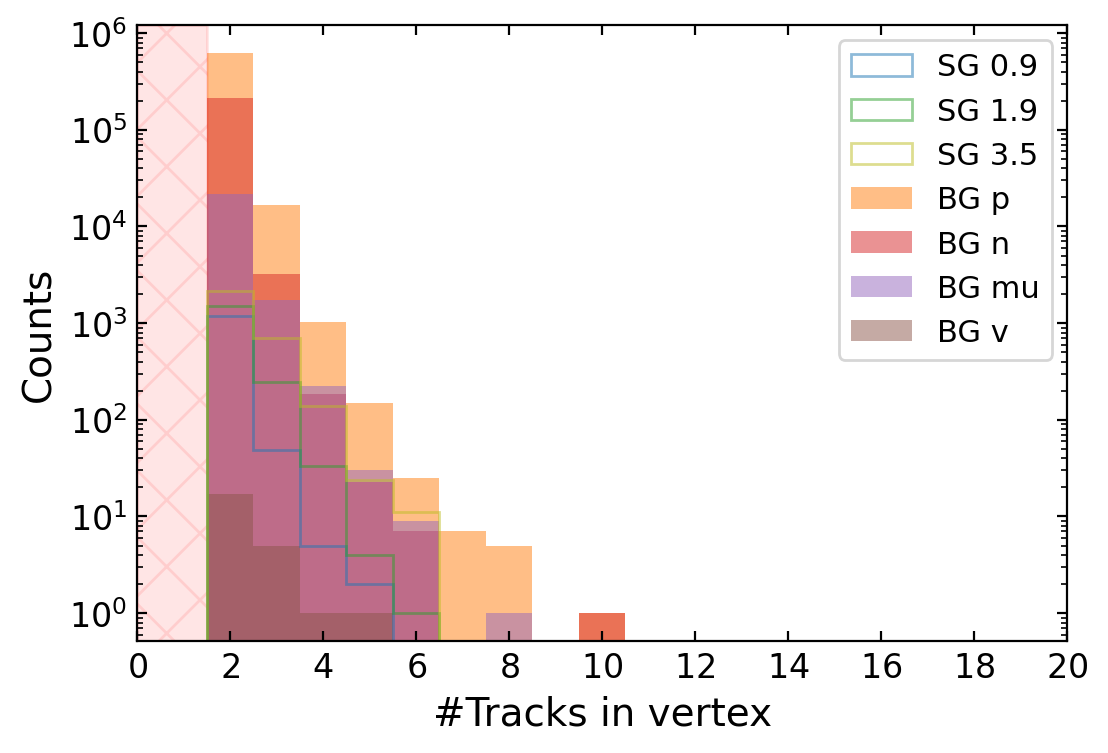

In [22]:
for name, cfg in plot_settings.items():
    res = data[name]
    plt.hist(res["vertex_ntracks"], bins=21,range=(-0.5,20.5), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)


plt.axvspan(0,NTRACK+0.5,color="r", alpha=0.1, hatch="X")


plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("#Tracks in vertex")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0,20)
save_fig("comb_ntrack_hits")
plt.show()

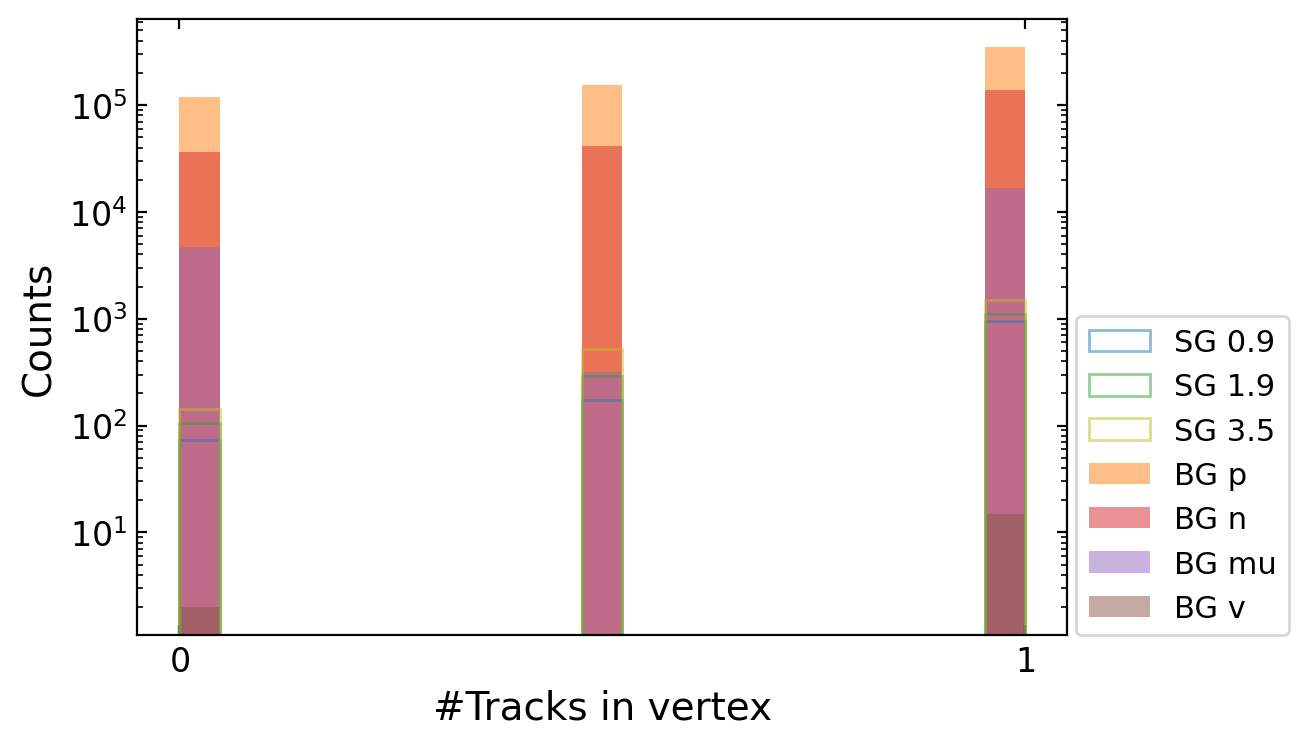

In [34]:
for name, cfg in plot_settings.items():
    res = data[name]
    plt.hist(res["vertex_topfrac"][res["vertex_ntracks"]==2], bins=21,range=(0,1), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)




plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("#Tracks in vertex")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

1225
0.0 4.0


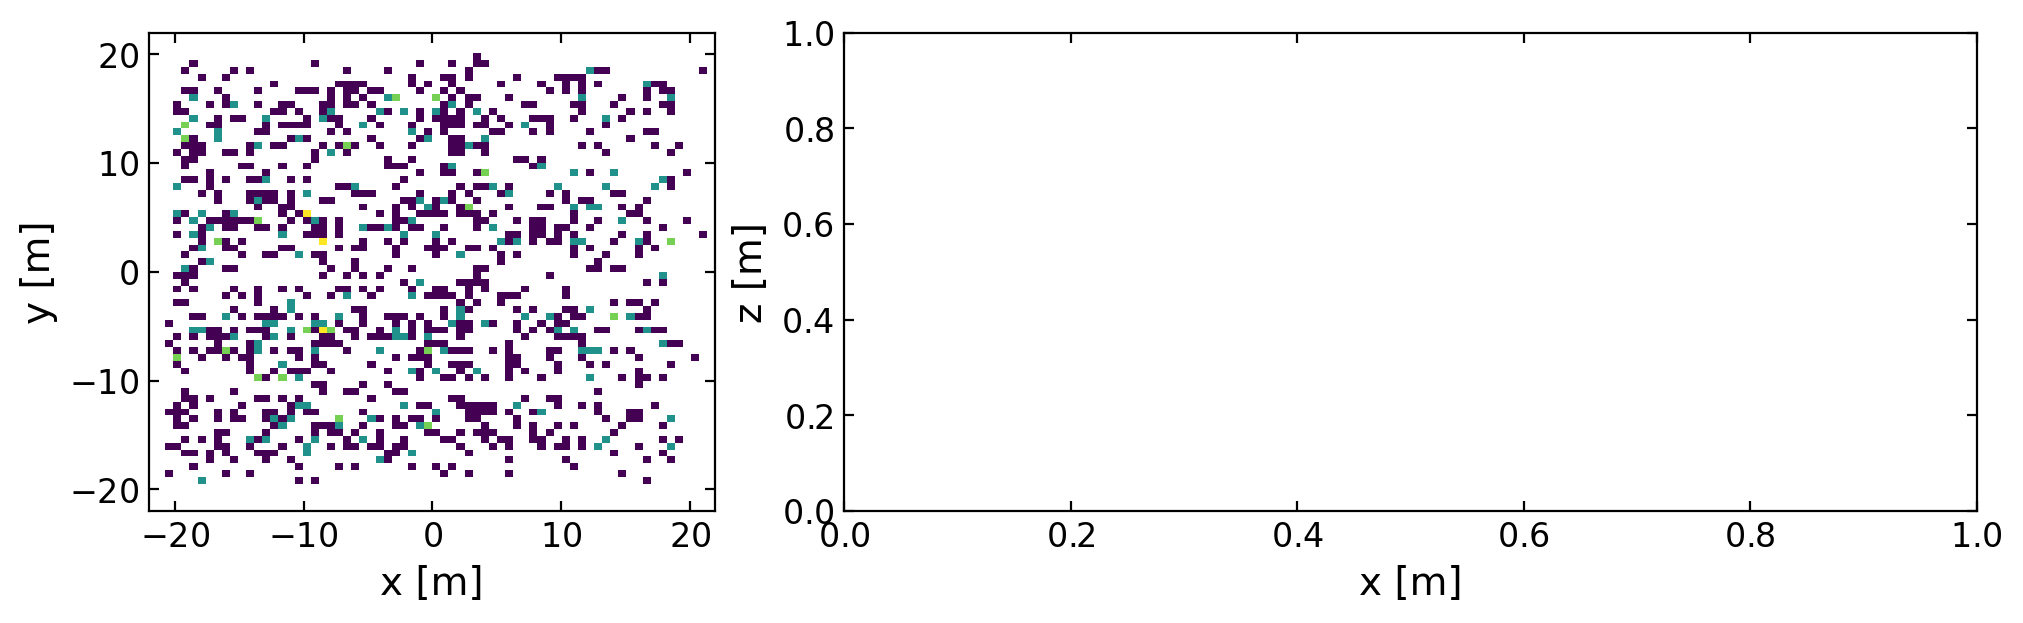

1756
0.0 5.0


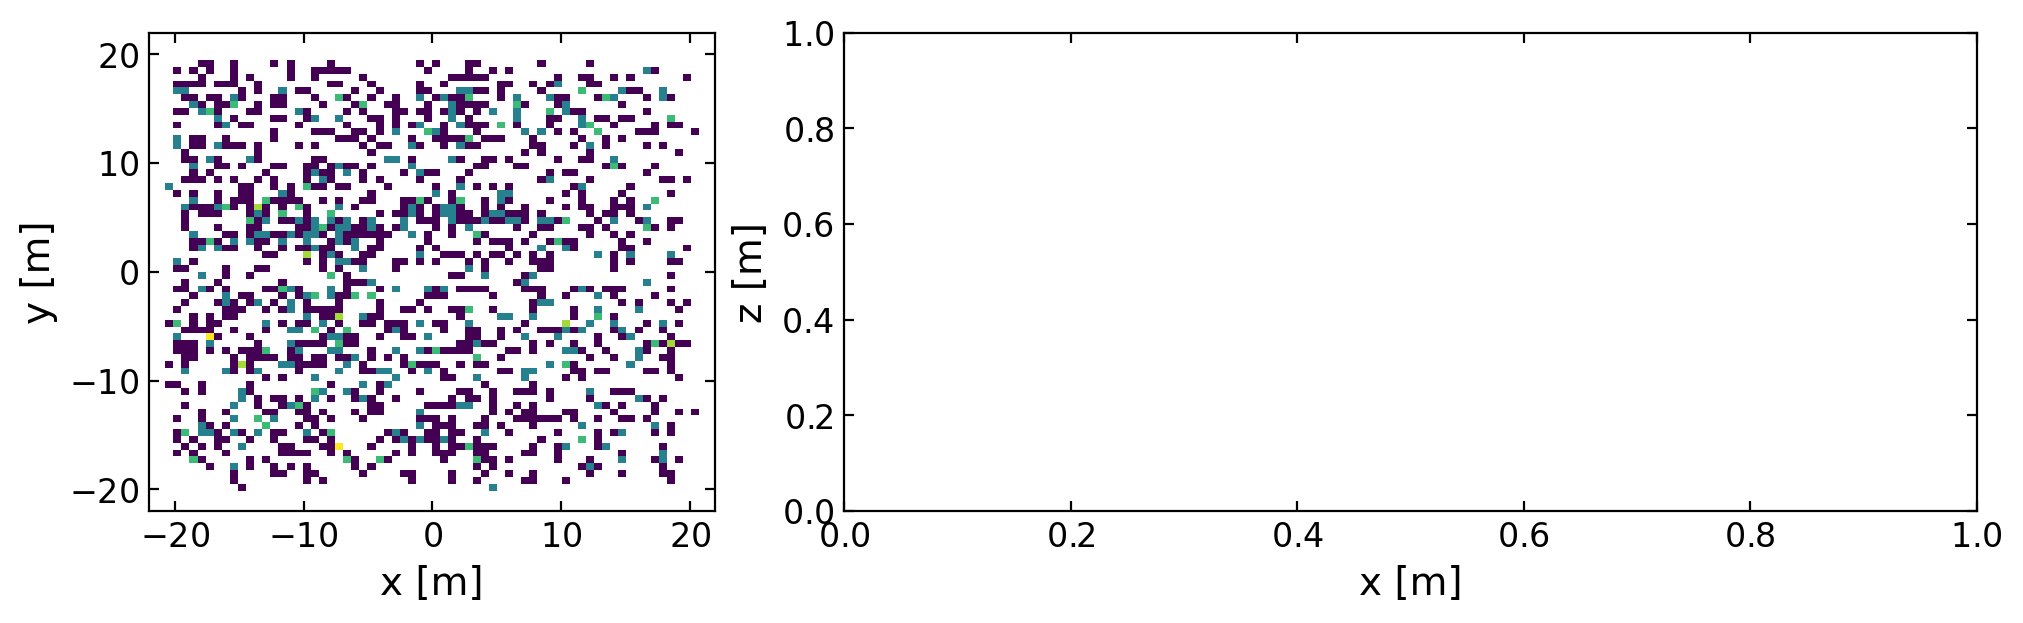

2976
0.0 7.0


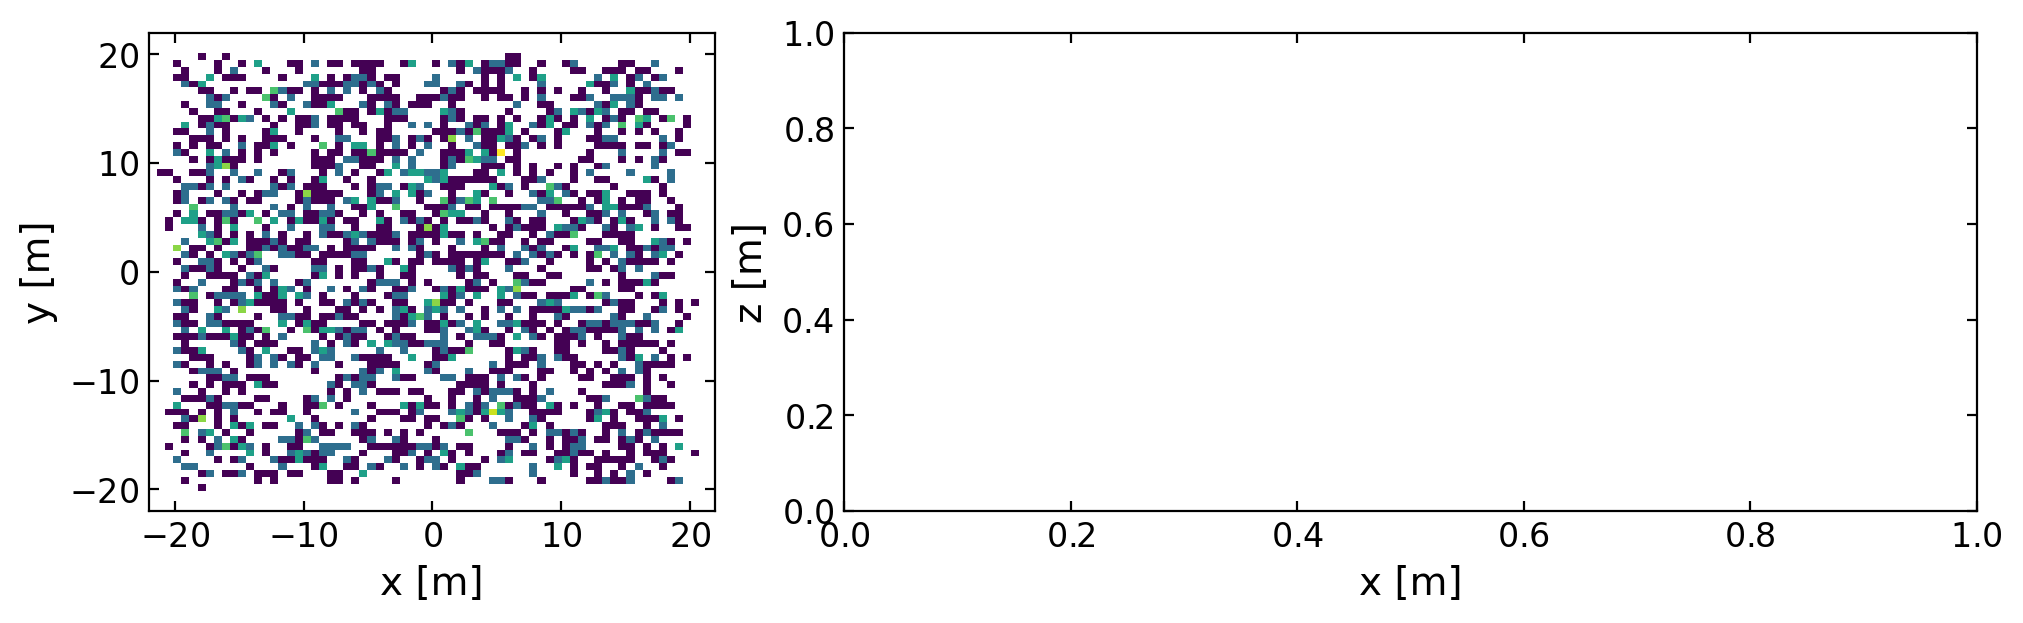

566577
0.0 576.0


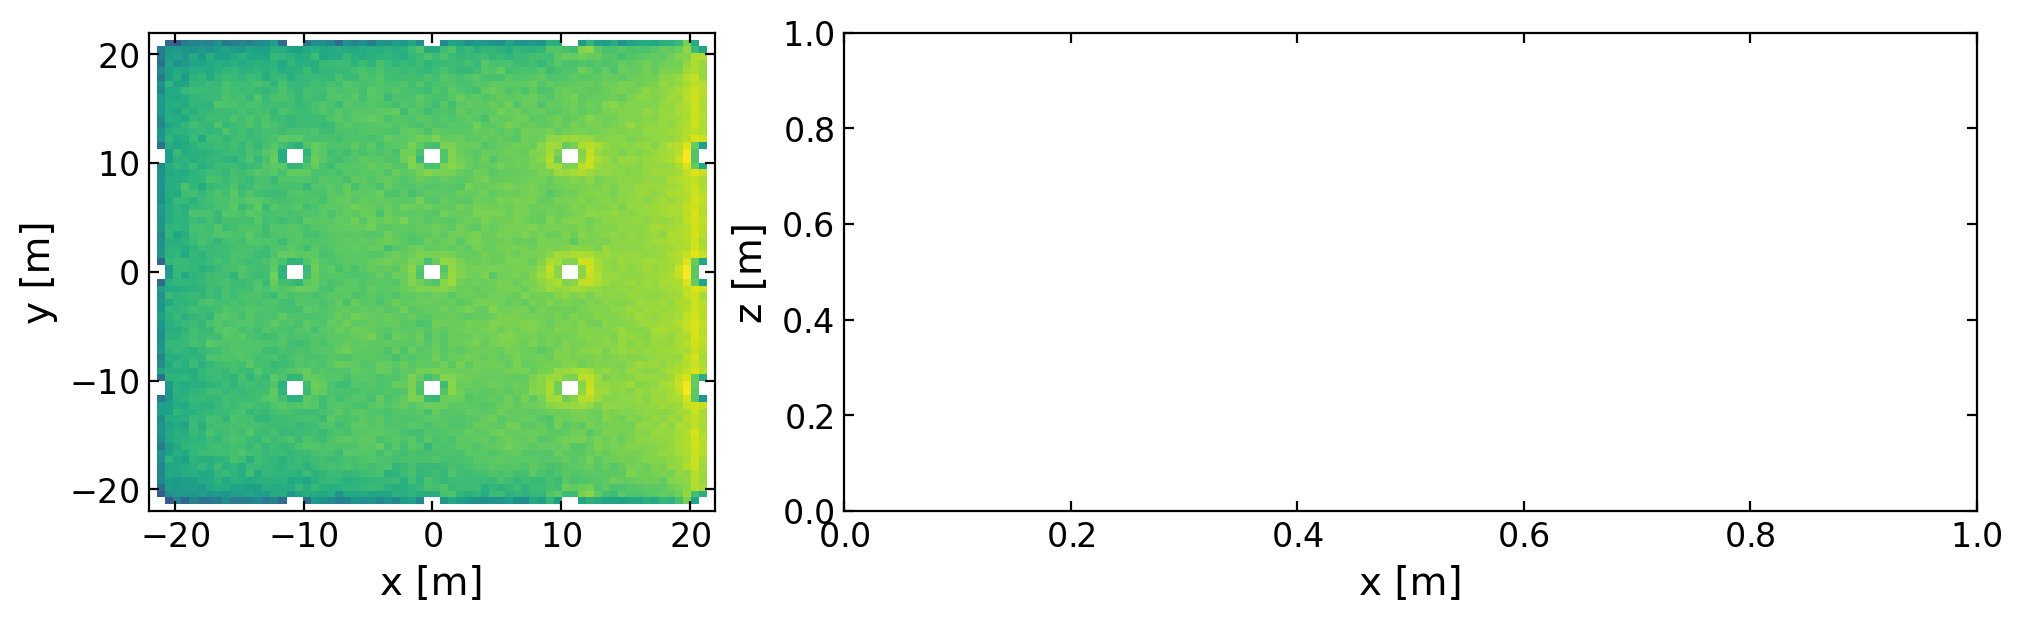

200440
0.0 141.0


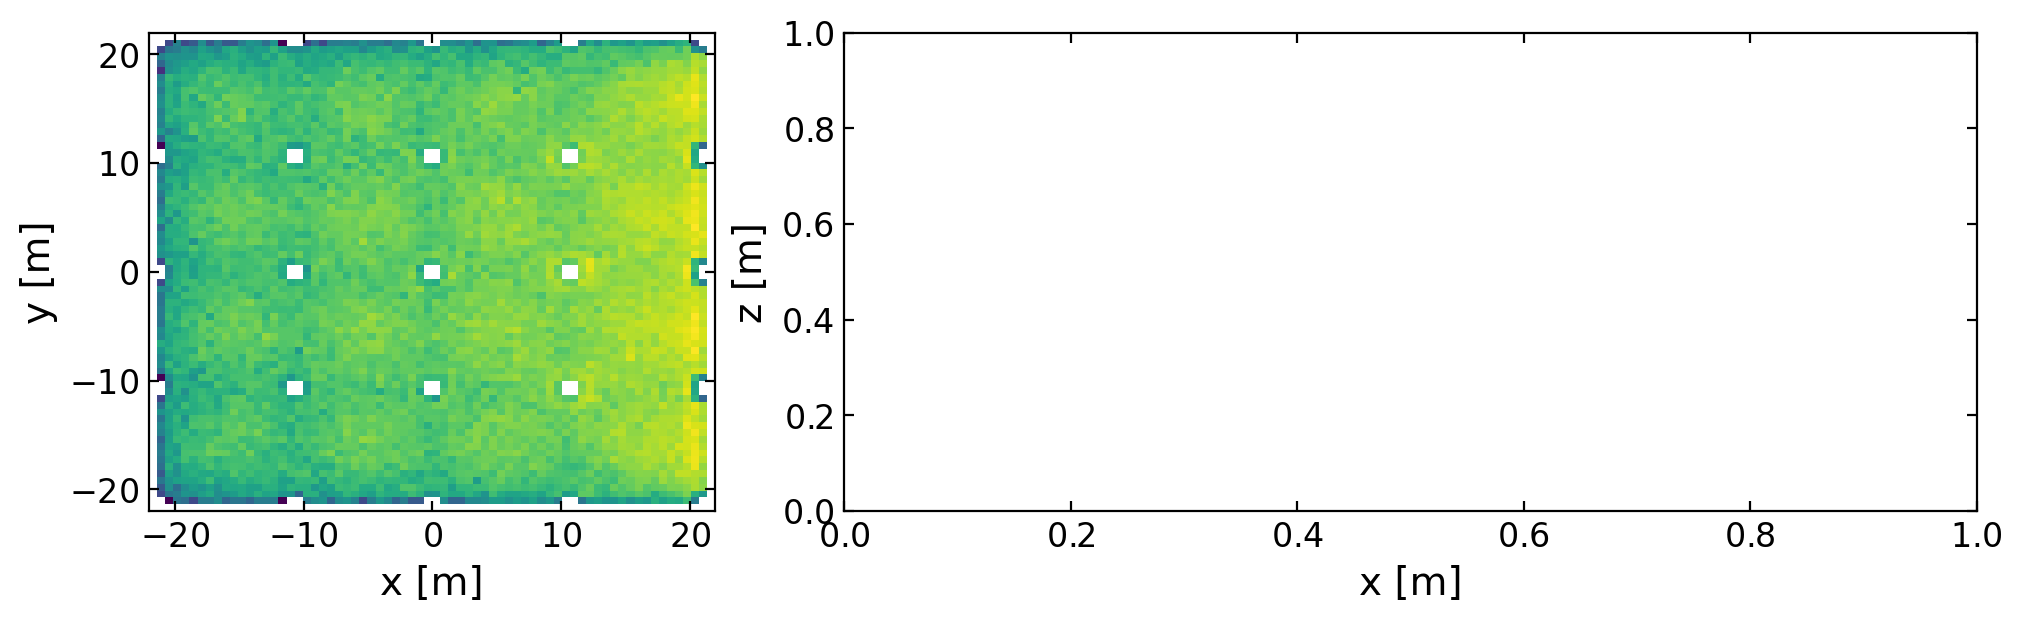

23056
0.0 27.0


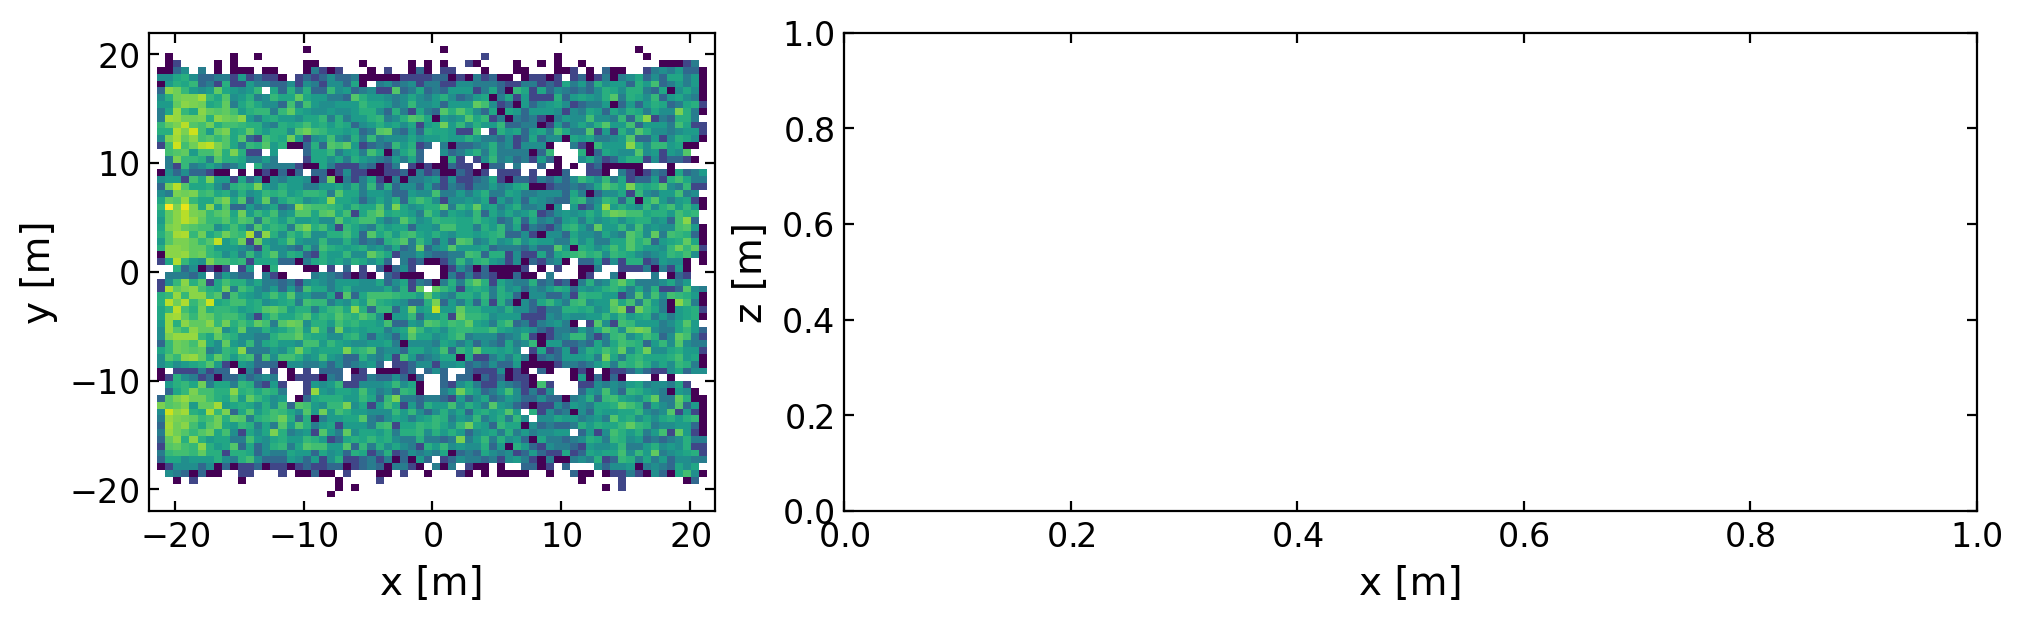

22
0.0 2.0


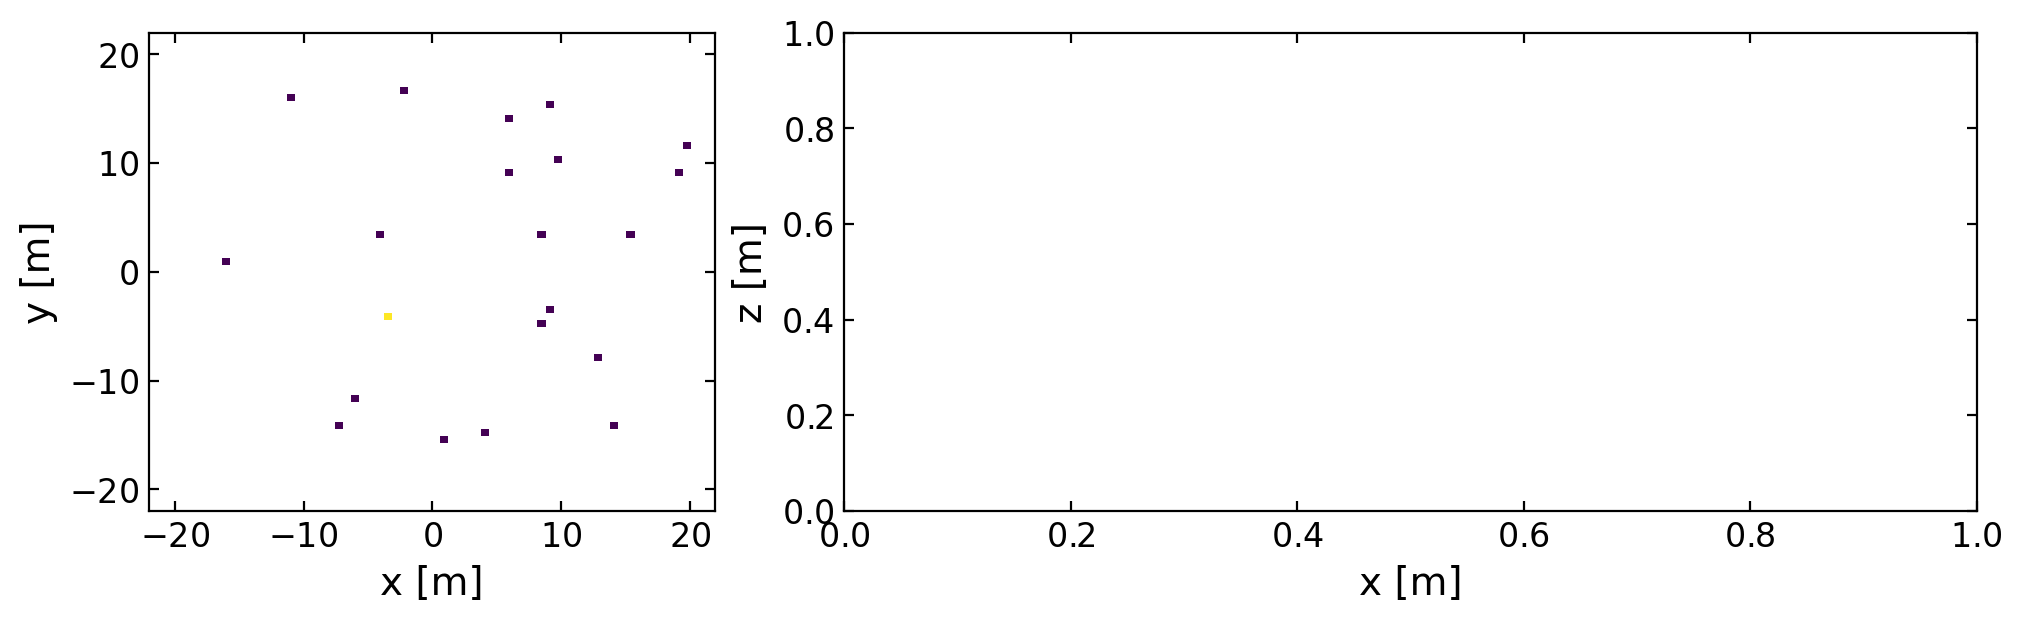

In [110]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask =  res.get_cut("Fiducial volume") # & res.get_cut("N track downward")#| res.get_cut("True") res.get_cut(f"More than 2 tracks") #
    mask_fid = res.get_cut("Fiducial volume")#| res.get_cut("True")
    print(sum(mask_fid))
    
    fig = plt.figure(figsize=(10,3), layout="constrained")
    spec = fig.add_gridspec(1,3)
    
    ax1 = fig.add_subplot(spec[:, :1])
    ax2 = fig.add_subplot(spec[:, 1:])


    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,1])[mask]/1000
    x_reject = (res["vertex_xyzt"][:,0])[mask&mask_fid]/1000
    y_reject = (res["vertex_xyzt"][:,1])[mask&mask_fid] /1000   
    h,xe,ye = hp.histogram2d(x, y, bins=(70,70), range=((-22,22),(-22,22)))
    print(np.min(h), np.max(h))
    ax1.hist2d(x, y, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.hist2d(x_reject, y_reject, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.scatter(x_reject, y_reject, alpha=0.83, s=1, color="r")
    # plt.colorbar()
    ax1.set_xlabel("x [m]")
    ax1.set_ylabel("y [m]")

    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,2])[mask]/1000
    # ax2.hist2d(x, y, bins=(80,40), norm=mpl.colors.LogNorm())
    ax2.set_xlabel("x [m]")
    ax2.set_ylabel("z [m]")
    
    plt.show()

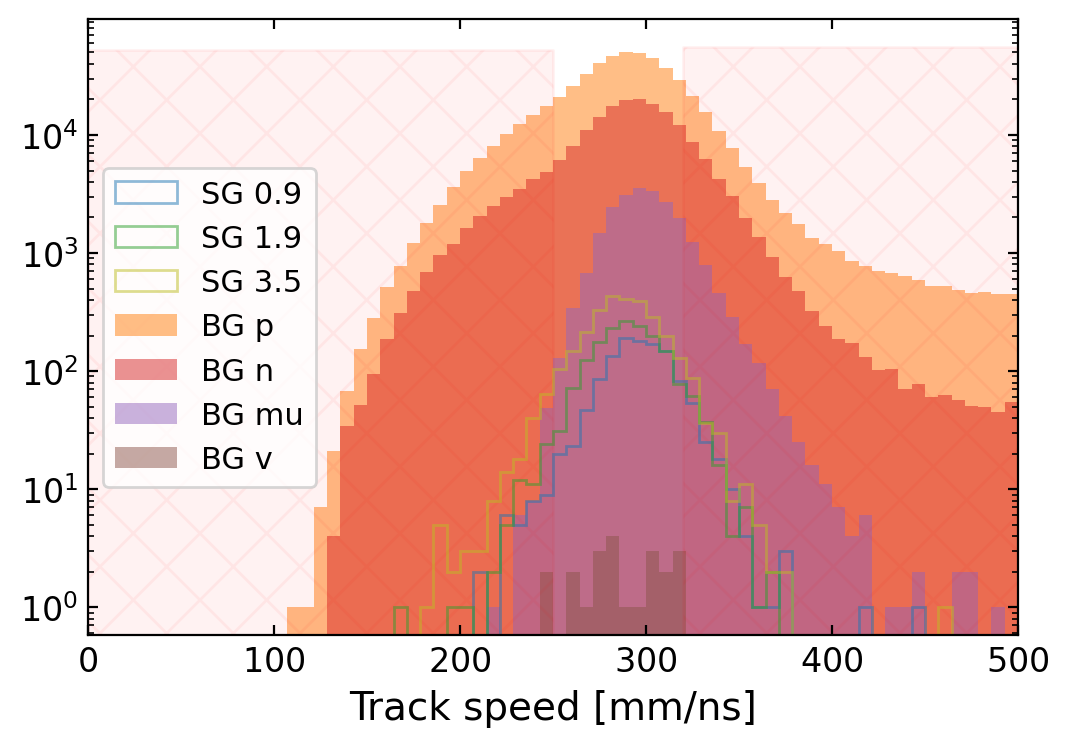

In [112]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask = res.get_cut("Fiducial volume")#& res.get_cut("N track downward")
    # mask = res.get_cut(f"More than {NTRACK} tracks") & res.get_cut("Fiducial volume")
    
    plt.hist(res["vertex_slowest_track"][mask], bins=70,range=(0,500),alpha=0.5, color=cfg.color, label=cfg.label, histtype=cfg.histtype)

    
plt.xlabel("Track speed [mm/ns]")
# plt.ylim(1,2e3)
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0, 250, color="r", alpha=0.05, hatch="X")
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 320, 500, color="r", alpha=0.05, hatch="X")

plt.xlim(0,500)
plt.yscale("log")
plt.legend()
save_fig("comb_track_speed")
plt.show()

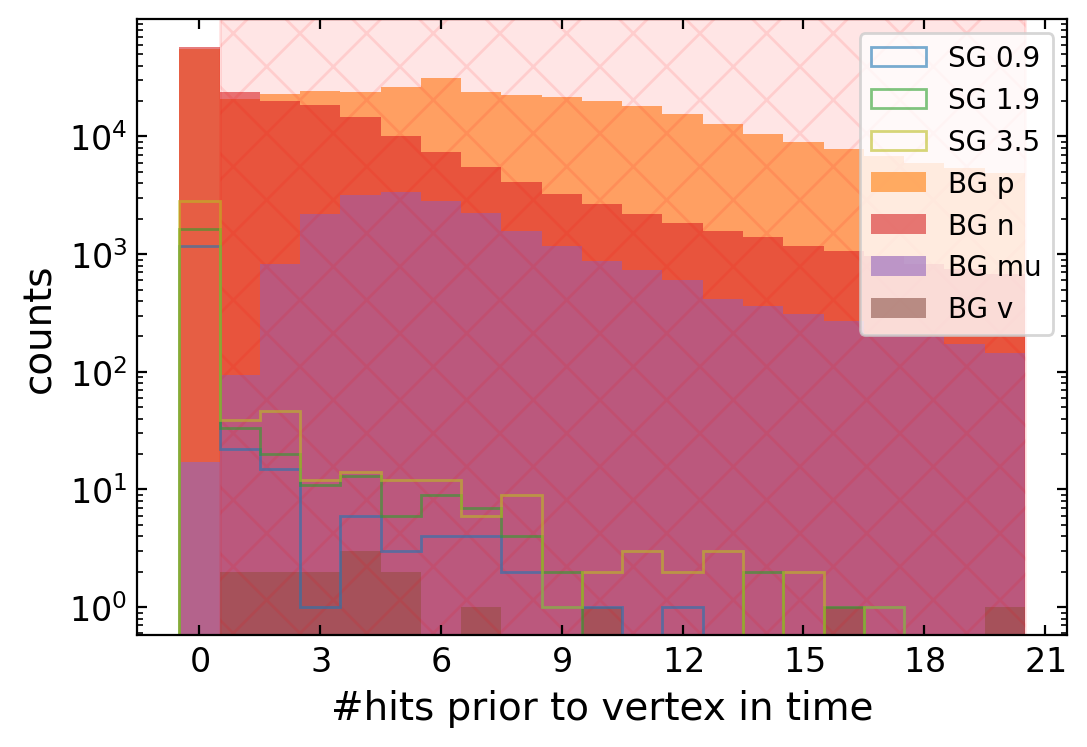

In [113]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask =  res.get_cut("Fiducial volume") # res.get_cut("N_hits vs N_veto") &res.get_cut("N_hits vs N_veto 2") #| res.get_cut("True") res.get_cut("N track downward") & res.get_cut("Track velocity") &
    plt.hist(res["vertex_ndigi_before_limited"][mask], range=(-0.5,20.5), bins=21, alpha=0.6,\
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)

plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))

plt.xlabel("#hits prior to vertex in time")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()
plt.axvspan(0.5,20.5,color="r", alpha=0.1, hatch="X")

lh = plt.legend(fontsize=10)
save_fig("comb_nhits_prior")


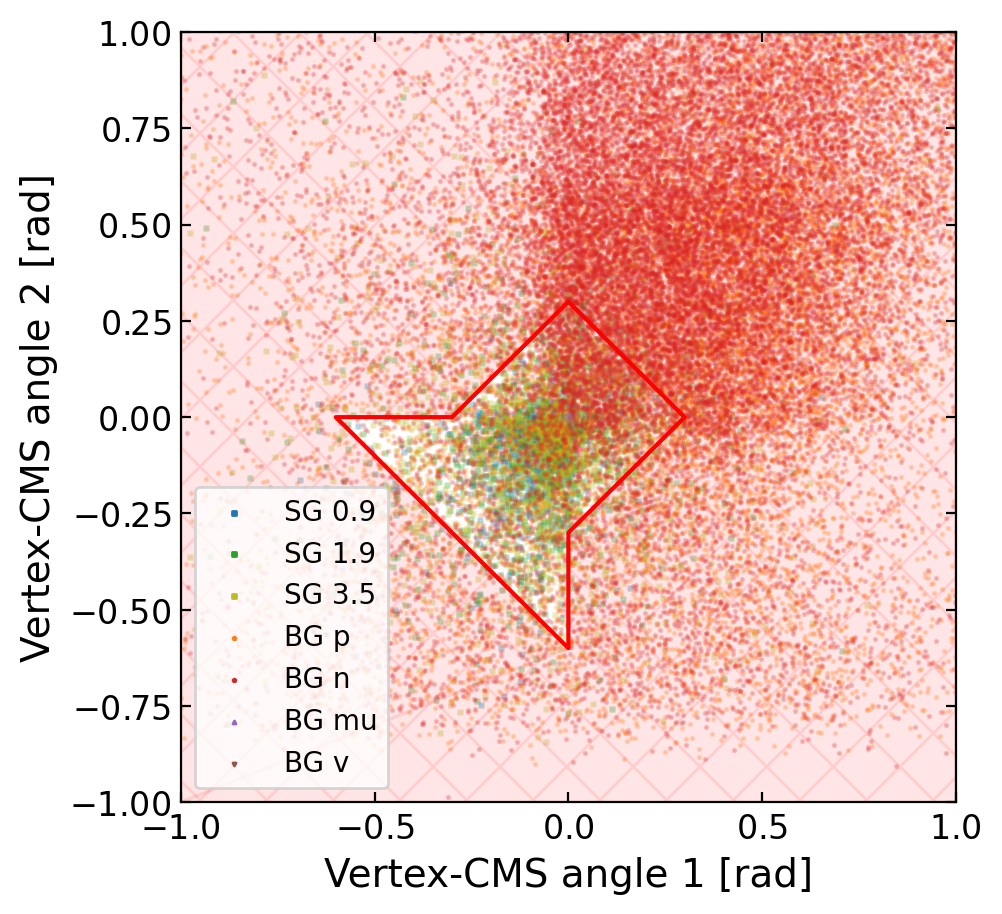

In [123]:

cut_angel_v1 = 0.3
cut_angel_v2 = 0.6
c_angle_hv = lambda data: (abs(res["vertex_cms_angle_h"]) + abs(res["vertex_cms_angle_v"]) < cut_angel_v1) | \
        (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))


plt.figure(figsize=(5,5))
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask =  res.get_cut("N track downward") & res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") #& res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2") # &res.get_cut("N_tracks")  | res.get_cut("True")
    
    x = (res["vertex_cms_angle_h"])[mask]
    y = res["vertex_cms_angle_v"][mask]
    alpha = cfg.alpha_marker*0.4 if "sig" in name else cfg.alpha_marker
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=alpha, s=cfg.markersize*0.3)


# Plot the cut region
poly = [[-cut_angel_v1,0], [0, cut_angel_v1], [cut_angel_v1,0], [0, -cut_angel_v1], [0,-cut_angel_v2], [-cut_angel_v2,0]]
polt_out = np.transpose(hplt.fill_outside(np.transpose(poly)[0],np.transpose(poly)[1], [-1,-1],[1,1]))

col1 = mpl.collections.PolyCollection([poly], edgecolors="r")
col1.set_linewidth(1.5)
col1.set_facecolor("none")  # Transparent face
col = mpl.collections.PolyCollection([polt_out], edgecolors="r", alpha=0.1, hatch="X")
col.set_facecolor('r')  # Transparent face
plt.gca().add_collection(col1)
plt.gca().add_collection(col)




plt.xlabel("Vertex-CMS angle 1 [rad]")
plt.ylabel("Vertex-CMS angle 2 [rad]")
# plt.yscale("log")
plt.xlim(-1,1)
plt.ylim(-1,1)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque

save_fig("comb_cms_angle")

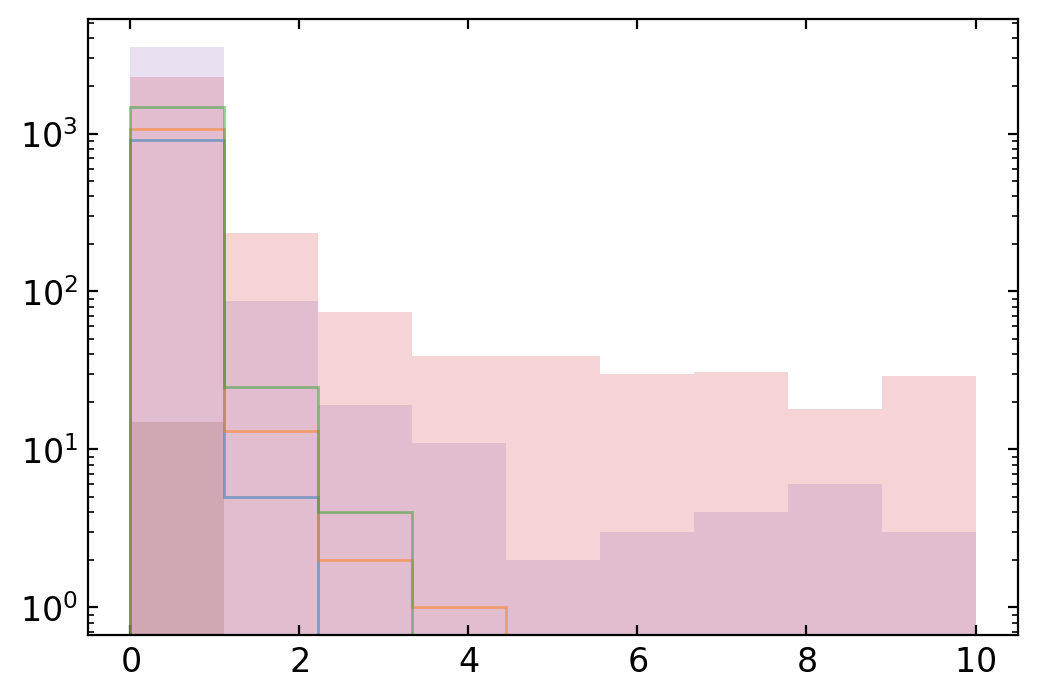

In [127]:
f_ndown_cut = lambda x: ((x-6)*.8 + 0.5) * (x >=6) + 0.5 * (x<6)

for name, cfg in plot_settings.items():
    # if "bkg" in name:
    #     continue
    
    res = data[name]
    # mask = res.get_cut("Fiducial volume")
    mask =  res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS")
    
    x = (res["event_ntracks"])[mask]
    y = (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])[mask]
    # y = (res["event_ndownward_track"])[mask]
    # plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize*4)

    plt.hist(y, bins=np.linspace(0,10,10), histtype=cfg.histtype, log=1, alpha=cfg.alpha_marker)



# xlim=30
# ylim=30
# x_plot = np.linspace(0,xlim,100)
# plt.plot(x_plot, f_ndown_cut(x_plot), color="r", linestyle=":")
# plt.fill_between(x_plot, f_ndown_cut(x_plot), ylim, color="r", alpha=0.05, hatch="X")
# plt.xlabel("#track")
# plt.ylabel("#track downwards")
# plt.xlim(0,xlim)
# plt.ylim(0,ylim)
# lh = plt.legend(fontsize=11)

# # make legend non-transparent
# for handle in lh.legend_handles:
#     handle.set_alpha(1.0)  # Make legend items fully opaque

# # Save figure
# save_fig("comb_n_downward_track")


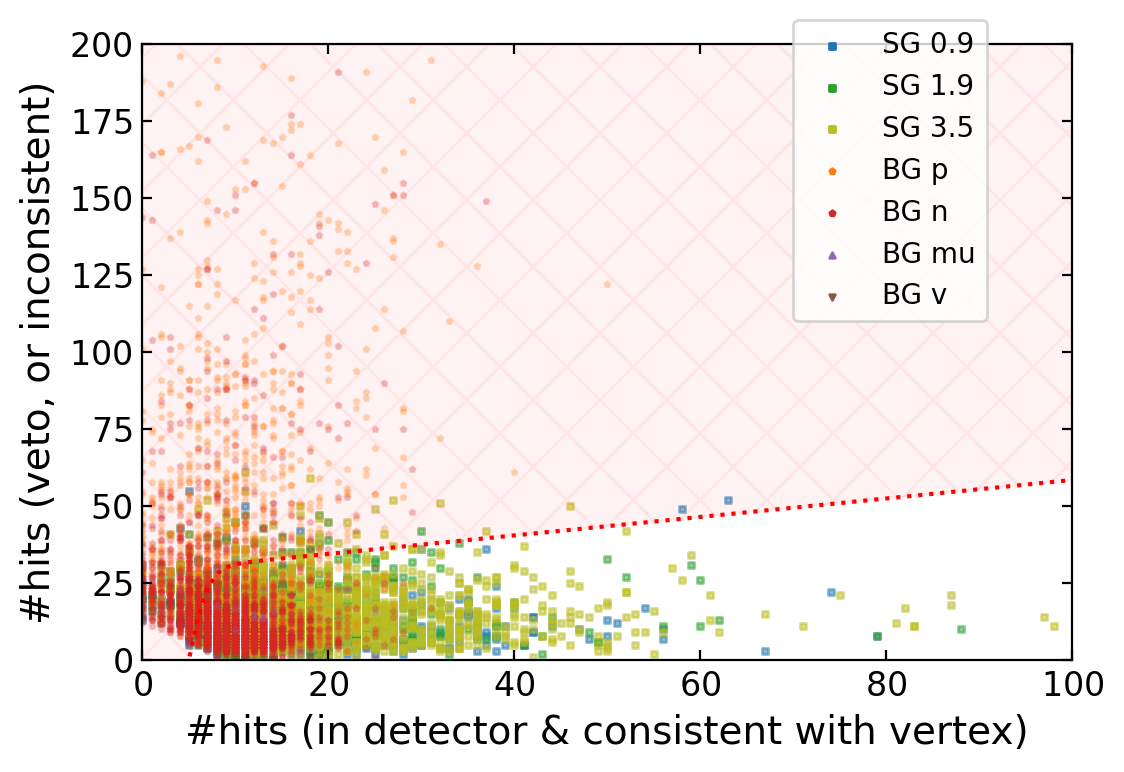

In [167]:
def f_nhits_cut(x):
    x0 = 5
    squeeze = 2
    yscale = 30
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y

for name, cfg in plot_settings.items():
    res = data[name]

    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") 
    x = (res["vertex_ndigi_active_after_comp"])[mask]
    y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)


xlim = 100
ylim = 200
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut(x_plot), ylim, color="r", alpha=0.05, hatch="X")
plt.xlabel("#hits (in detector & consistent with vertex)")
plt.ylabel("#hits (veto, or inconsistent)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10, loc=(0.7,0.55))
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque


save_fig("comb_n_veto_cut_1")

801
886
1200
603
2074
9
0


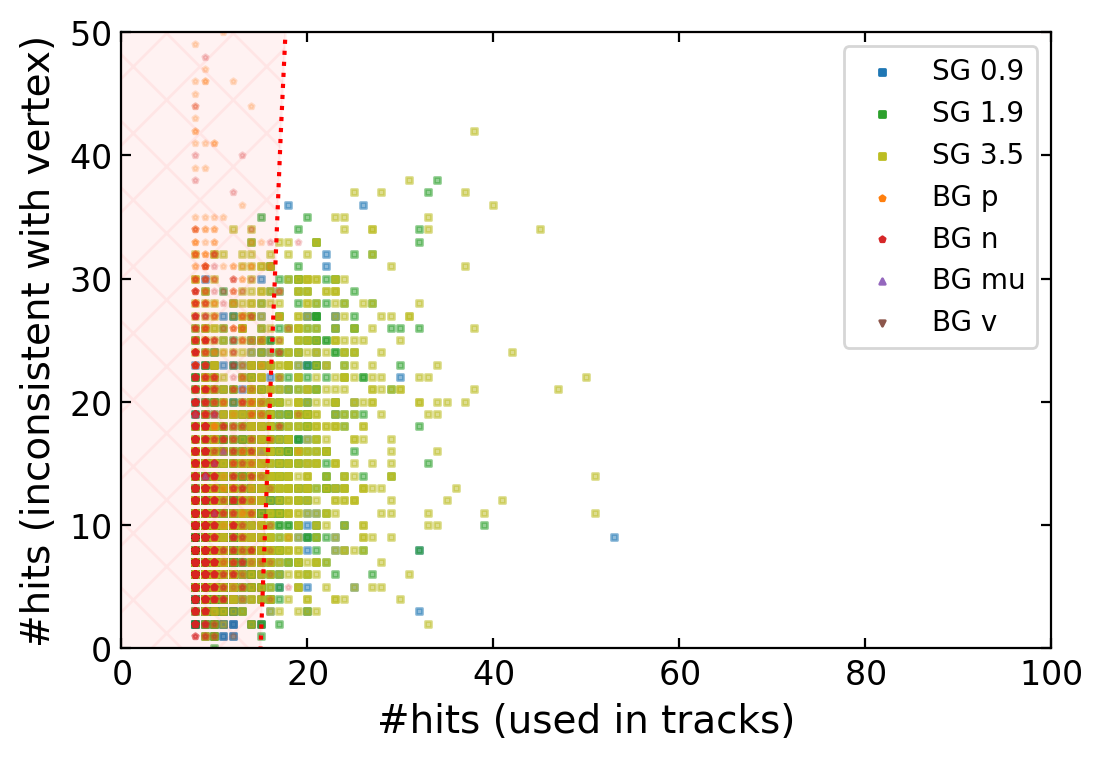

In [171]:
def f_nhits_cut2(x):
    x0 = 15
    squeeze = 5
    yscale = 100
    slope = 1
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    # return y * (y>20) + 20 * (y<=20)
    return y
    

for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto")

    x = (res["event_track_nhits"])[mask]
    y = (res["event_nhits"]- res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)
    print(sum(mask))

xlim=100
ylim=50
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut2(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut2(x_plot), ylim, color="r", alpha=0.05, hatch="X")

plt.xlabel("#hits (used in tracks)")
plt.ylabel("#hits (inconsistent with vertex)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque
    
save_fig("comb_n_veto_cut_2")

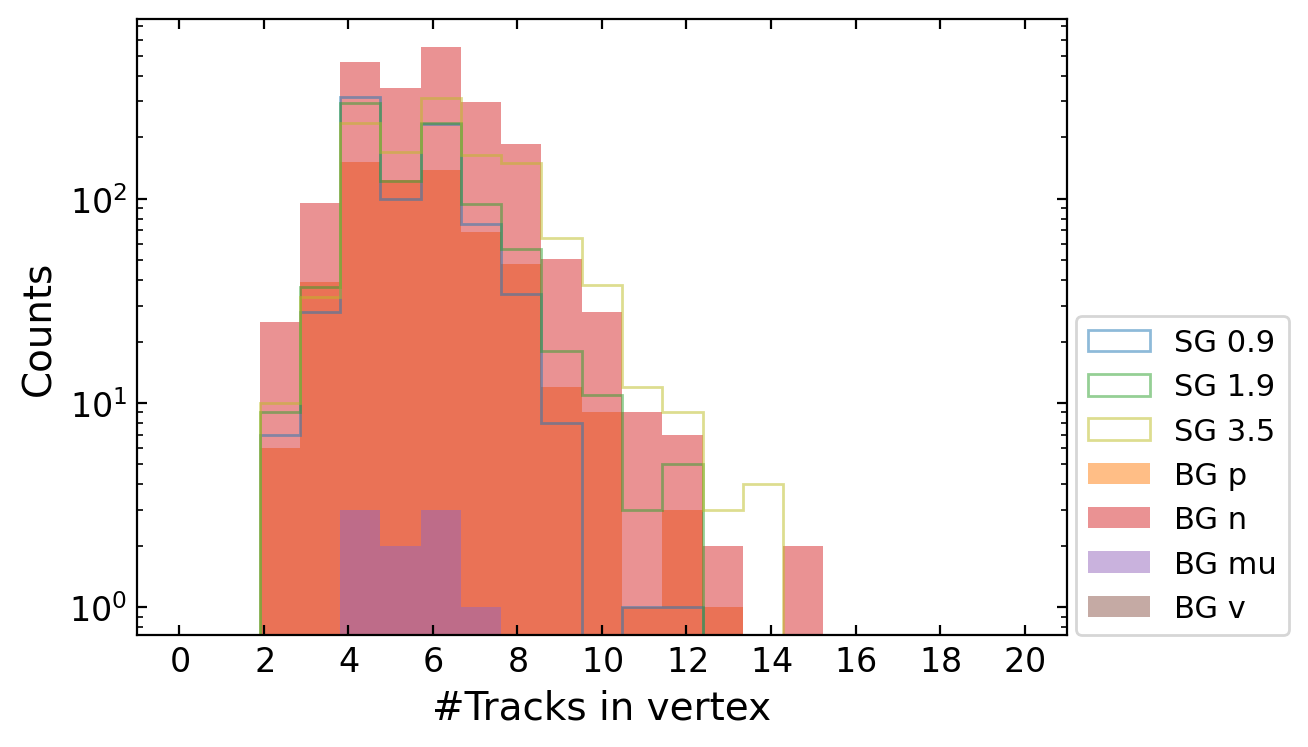

In [174]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto")
    plt.hist((res["vertex_ntracks"]+ res["vertex_ntracklet_3+"])[mask], bins=21,range=(0,20), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)




plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("#Tracks in vertex")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

---
Plot event

In [39]:
i=5
fname_recon_sig  =   f"{data_dir}/llp_sms/run_{i}_digi_cosmic_recon_skim.root"
fsig1 = root.tfile_reader(fname_recon_sig)
fsig1.get_tree("metadata_digi")
metadata_digi = fsig1.get_entry(0)
fsig1.get_tree("data;1")
print(f"Entries", fsig1.entries)

Entries 3340


98


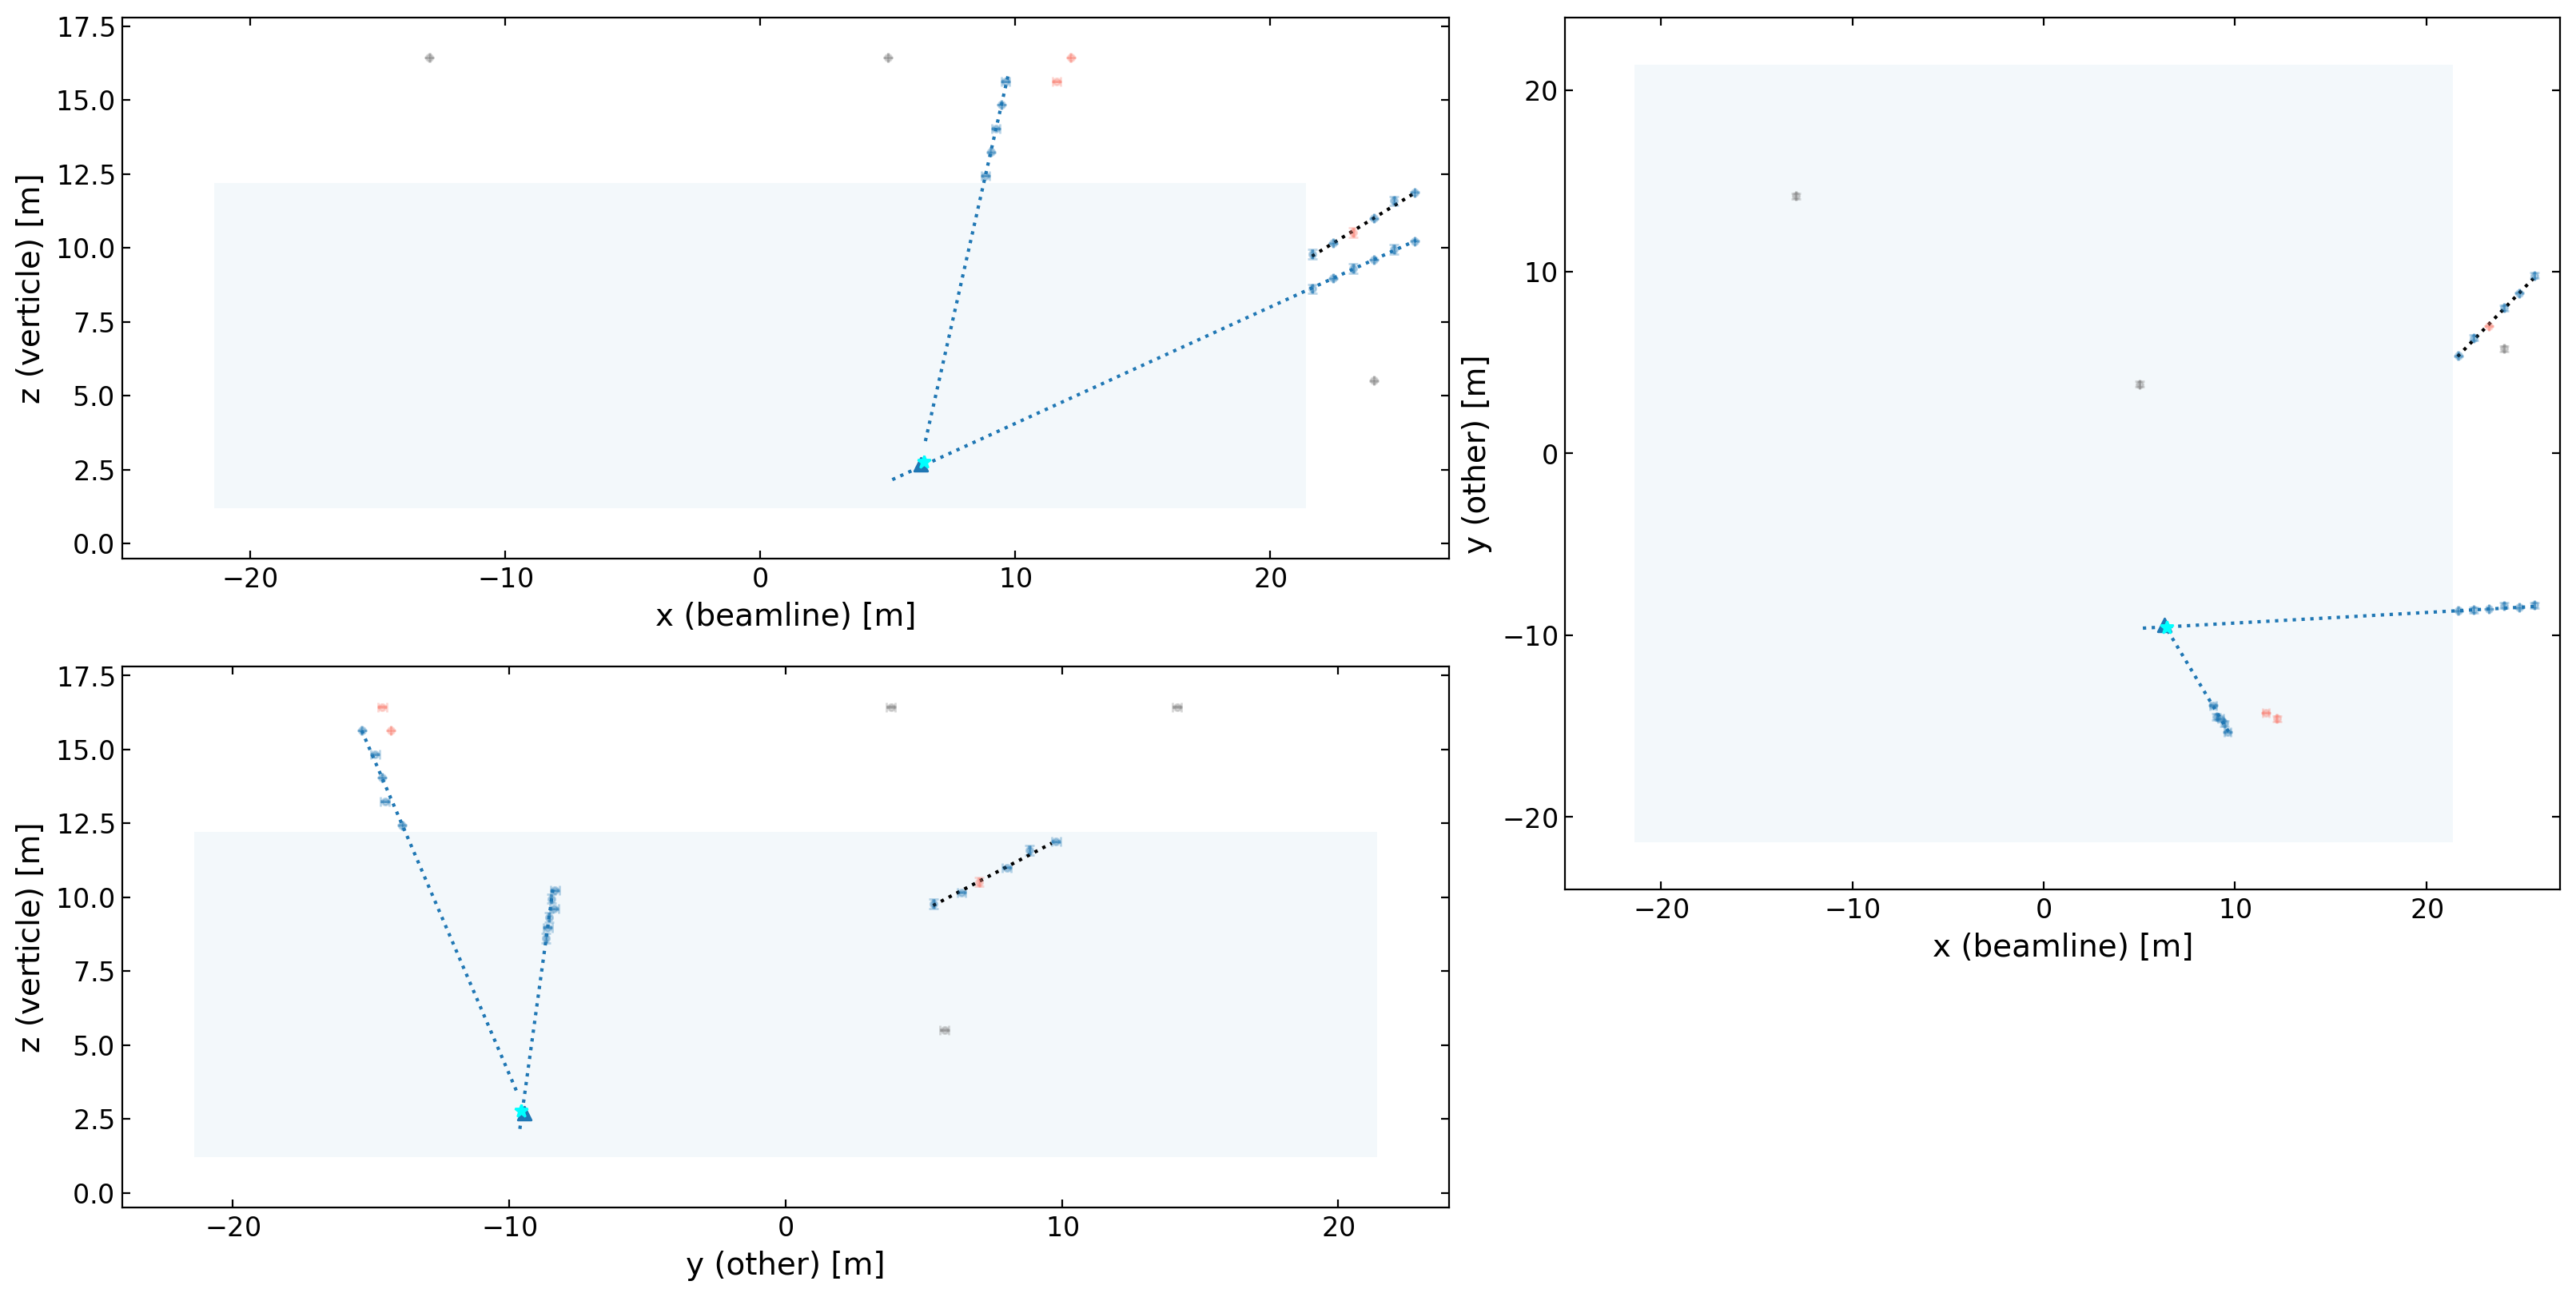

In [162]:
i+=1
# i=0
print(i)

rawdata = fsig1.get_entry(i)
event = datatypes.Event(rawdata, metadata_digi)  
event.plot()


In [175]:
fname_comb_p = f"{data_dir}/cedar/cosmic/cosmic_p/merged_p_1200runs.root"
fname_comb_n = f"{data_dir}/cedar/cosmic/cosmic_n/merged_n_2172runs.root"
fname_comb_v = f"{data_dir}/cedar/neutrino/merged.root" # On cedar: /project/6049244/data/MATHUSLA/simulation/run-2024-07-cosmic-neutrino/v2_recon_and_skim/merged.root
fname_comb_mu = f"{data_dir}/cedar/muon/merged.root"# On cedar: /project/6049244/data/MATHUSLA/simulation//run-2024-07-mathusla40-full/v2_recon_and_skim/merged.root

fbkg = root.tfile_reader(fname_comb_p)
fbkg.ls()
## Get metadata
fbkg.get_tree("metadata_digi")
metadata_digi = fbkg.get_entry(0)
fbkg.get_tree("data;1")
print("Entries", fbkg.entries)

fbkg_n = root.tfile_reader(fname_comb_n)
# fbkg_n.ls()
fbkg_n.get_tree("data;1")
print("Entries", fbkg_n.entries)

fbkg_v = root.tfile_reader(fname_comb_v)
# fbkg_n.ls()
fbkg_v.get_tree("data;1")
print("Entries", fbkg_v.entries)

fbkg_mu = root.tfile_reader(fname_comb_mu)
# fbkg_n.ls()
fbkg_mu.get_tree("data;1")
print("Entries", fbkg_mu.entries)

None
Entries 839934
Entries 290908
Entries 30
Entries 24729
TFile**		/home/tomren/geant_projects/musim_test//cedar/cosmic/cosmic_p/merged_p_1200runs.root	
 TFile*		/home/tomren/geant_projects/musim_test//cedar/cosmic/cosmic_p/merged_p_1200runs.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TParameter<int>	N_MERGED;1	
  KEY: TTree	data;1	Reconstruction Tree Skimmed


In [176]:
data.keys()

dict_keys(['bkg p', 'bkg n', 'bkg mu', 'bkg v', 'sig 0.08', 'sig 0.88', 'sig 1.90', 'sig 3.48', 'sig 4.70'])

In [197]:
res = data['bkg n']
mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto")

plot_inds = res["ROOT_entry"][mask]

In [198]:
(plot_inds[:10])

array([ 152,  226,  405,  469,  525,  898, 1155, 1332, 1650, 1754])

90 12281
4


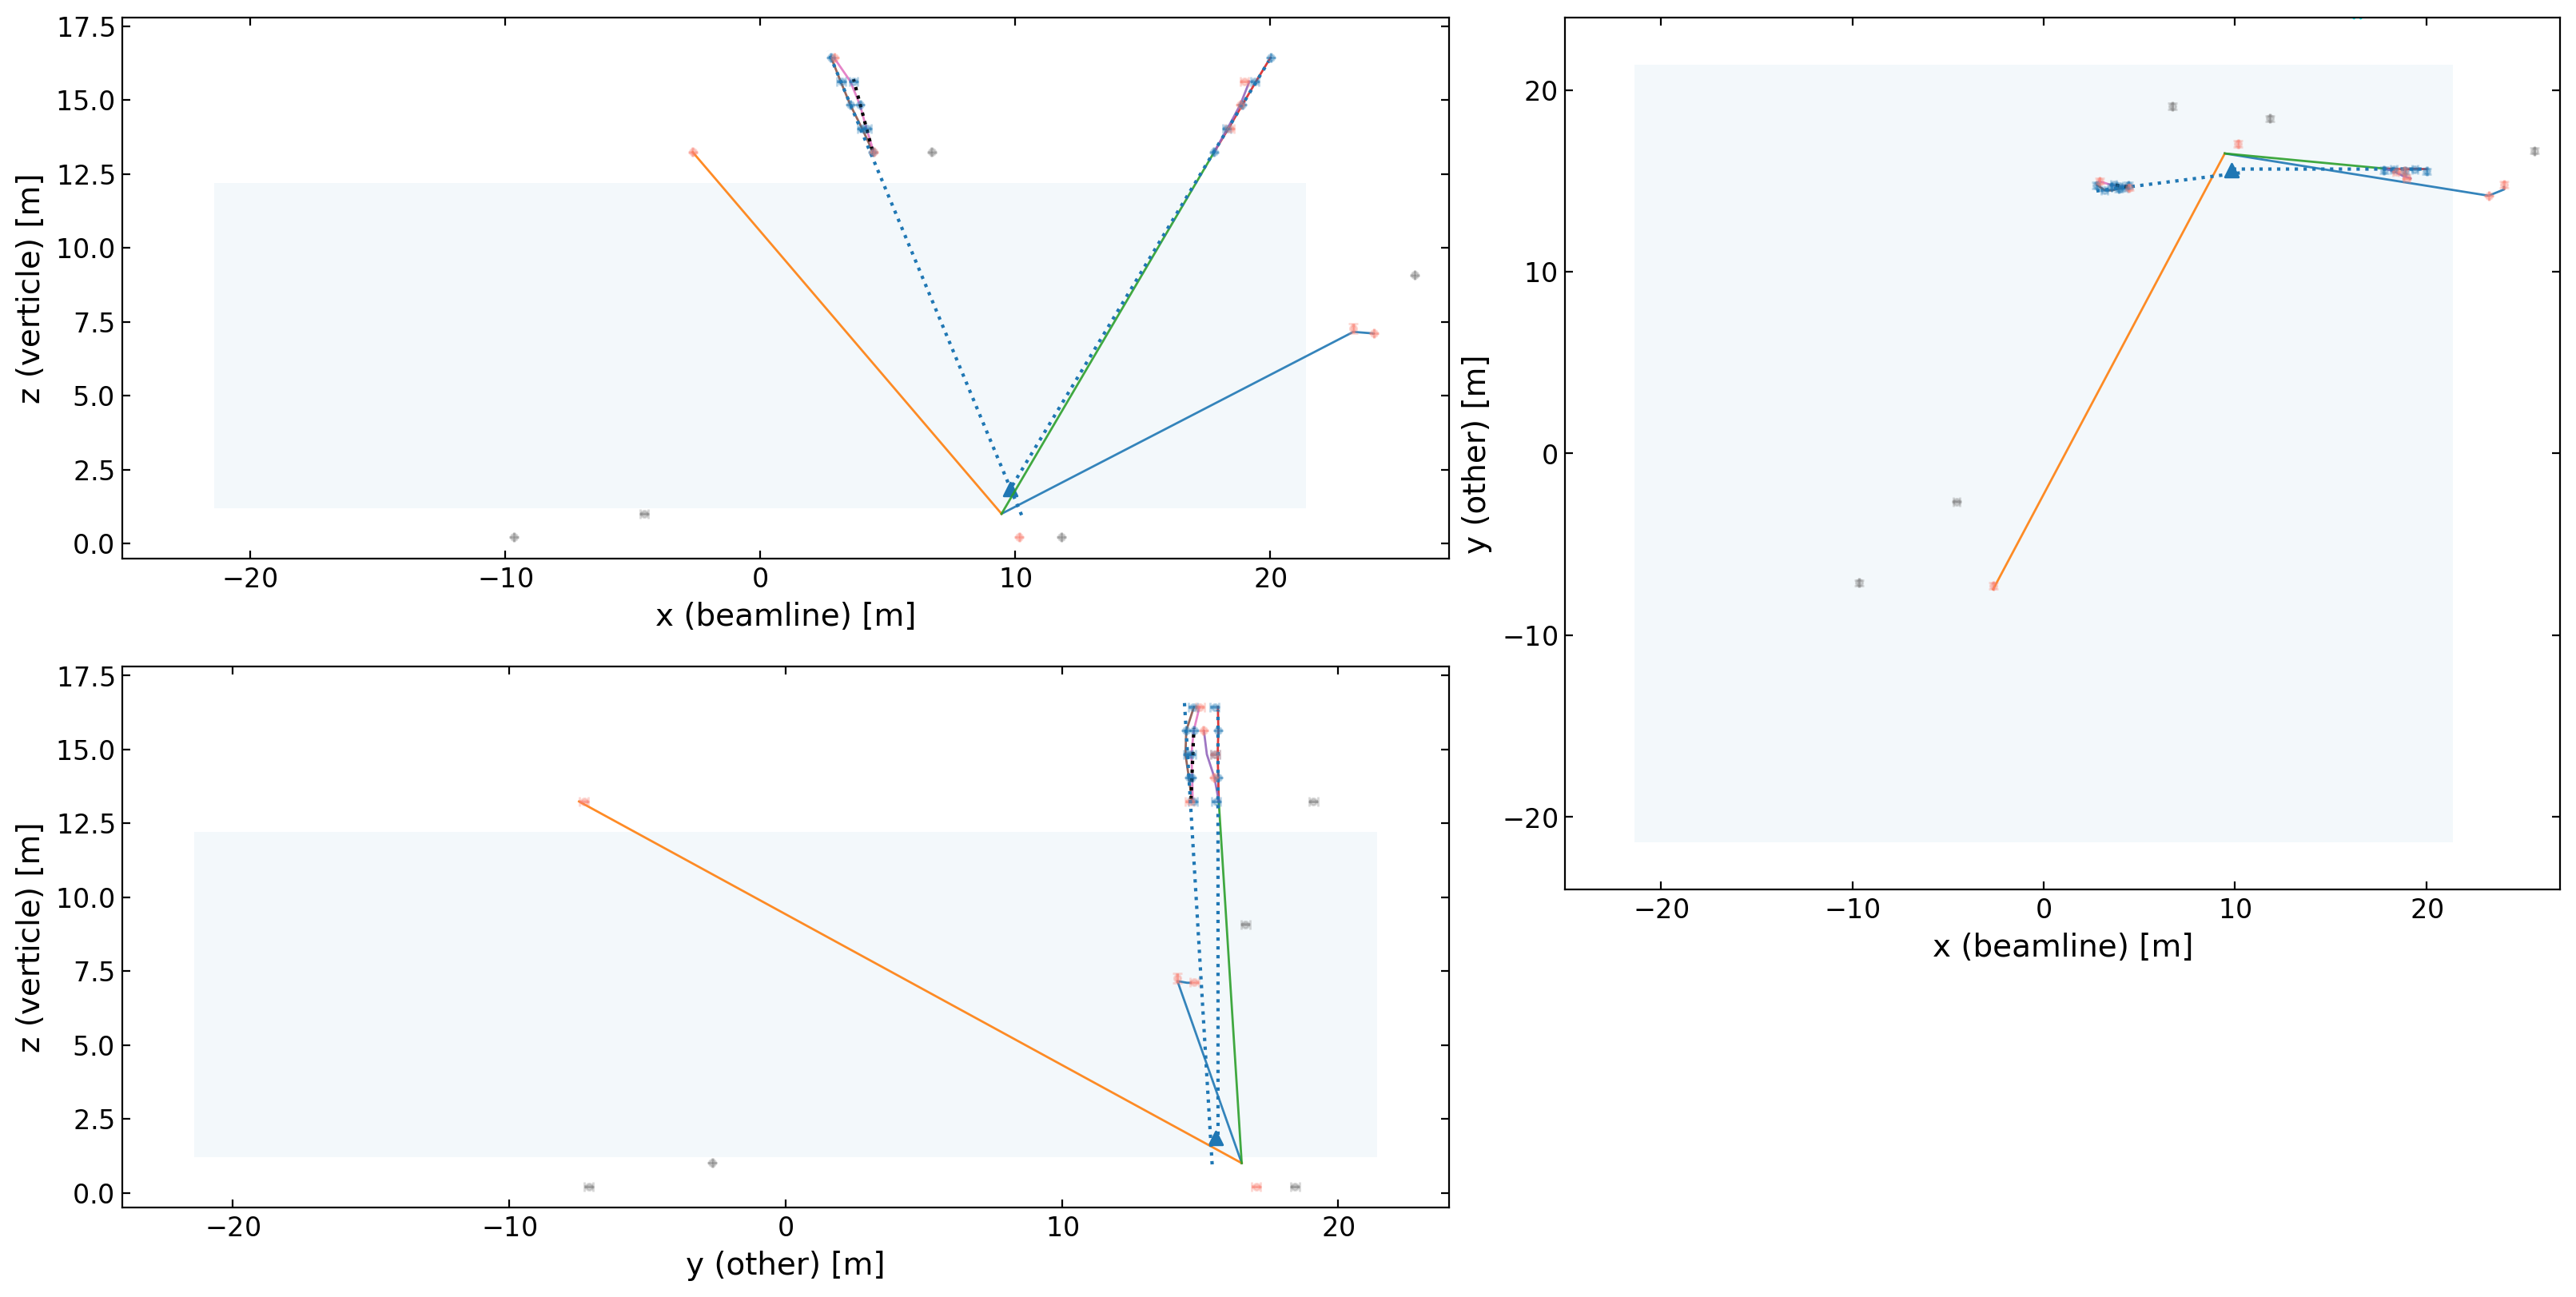

In [282]:
i+=1
# i=0
j=plot_inds[i]
print(i,j)

print( res["vertex_ntracklet_3+"][i])

rawdata = fbkg_n.get_entry(j)
event = datatypes.Event(rawdata, metadata_digi)  
event.plot()
